In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

# 15 Minutes

In [3]:
test15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/15min/test.tsv.gz',
                      sep='\t')
xval15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/15min/xval.tsv.gz',
                      sep='\t')

predict_test15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_15min_test.txt',
                   header = None)
predict_xval15=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_15min_xval.txt',
                   header=None)

In [4]:
# add predictions column to data frame
test15['ons_predicted'] = predict_test15
xval15['ons_predicted'] = predict_xval15
# create a column for the difference between the actual ons and predicted ons
test15['diff_ons_predicted']=test15['ons']-test15['ons_predicted']
xval15['diff_ons_predicted']=xval15['ons']-xval15['ons_predicted']

In [5]:
test15.columns,xval15.columns

(Index(['opd_date', 'trip_start_hr_15', 'rte', 'dir', 'day_of_week', 'is_ns',
        'is_rapid', 'is_weekend', 'orca_total', 'frac_disabled', 'frac_youth',
        'frac_senior', 'frac_li', 'frac_uw', 'ons', 'region', 'start', 'end',
        'type', 'summer', 'ons_predicted', 'diff_ons_predicted'],
       dtype='object'),
 Index(['opd_date', 'trip_start_hr_15', 'rte', 'dir', 'day_of_week', 'is_ns',
        'is_rapid', 'is_weekend', 'orca_total', 'frac_disabled', 'frac_youth',
        'frac_senior', 'frac_li', 'frac_uw', 'ons', 'region', 'start', 'end',
        'type', 'summer', 'ons_predicted', 'diff_ons_predicted'],
       dtype='object'))

## Test Set

In [6]:
# get sum by date
count_by_date_test_15 = test15.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_test_15['opd_date'] =pd.to_datetime(count_by_date_test_15['opd_date'])
count_by_date_test_15['dayofweek'] = count_by_date_test_15['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_test_15 = count_by_date_test_15.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_test_15

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  439201.0  29280.066667  4626.216573    15  419492.284524   
1         1  468056.0  31203.733333  1497.751384    15  454344.641346   
2         2  484379.0  30273.687500  1955.786652    16  472469.661139   
3         3  469935.0  29370.937500  4563.433378    16  450990.387538   
4         4  439792.0  27487.000000  2339.818597    16  432366.140304   
5         5  184967.0  11560.437500  1155.051685    16  179641.460213   
6         6  132902.0   9493.000000  1011.056036    14  128822.454672   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  27966.152302  3716.938865    15       19708.715476  1313.914365   
1  30289.642756  1624.496229    15       13711.358654   914.090577   
2  29529.353821  2027.725937    16       11909.338861   744.333679   
3  28186.899221  4008.585688    16       18944.612462  1184.038279   
4  27022.883769  1932.702573    16        7425.859696   464.116231   
5  11227.591263   903.637510    16        5325.539787   332.846237   
6   9201.603905   908.323068    14        4079.545328   291.396095   

                     
          std count  
0  980.552435    15  
1  492.181861    15  
2  519.063893    16  
3  889.328456    16  
4  738.558270    16  
5  349.609488    16  
6  249.225322    14

In [7]:
# Make plots...
def plot_by_day(acutal_mean, actual_errors, predicted_means, predicted_errors, dataset_name):
    
    labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    x_pos = np.arange(len(labels))
    width = .4

    # Build the plot
    fig, ax = plt.subplots(figsize=(8, 4))
    acutal = ax.bar(x_pos - width/2, acutal_mean,
            yerr=actual_errors,
            width = width,
            align='center',
            ecolor='black',
            capsize=4,
            label = 'Actual')

    predicted = ax.bar(x_pos+width/2, predicted_means,
            yerr=predicted_errors,
            align='center',
            ecolor='black',
            capsize=4,
            width = width,
            label = 'Predicted')

    ax.set_ylabel('Passenger Count')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)

    plt.suptitle('Predicted vs Acutal Average Ridership by Day', y=1, fontsize=18)
    plt.title(dataset_name, fontsize=14)

    # Save the figure and show
    ax.legend()
    plt.savefig(dataset_name +'.png')
    plt.show()

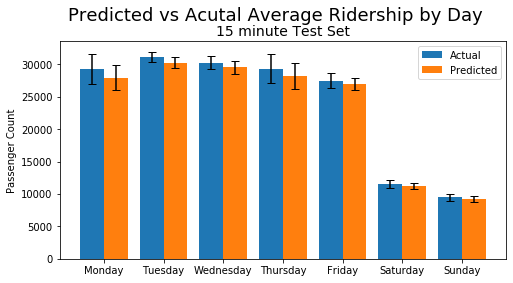

In [8]:
counts_by_day_test_15 = avg_passenger_count_by_day_test_15.ons['count']

ons_by_day_test_15 = avg_passenger_count_by_day_test_15.ons['mean']
ons_std_test_15 = avg_passenger_count_by_day_test_15.ons['std']
ons_error_test_15 = 1.96*ons_std_test_15/np.sqrt(counts_by_day_test_15)

predictions_by_day_test_15 = avg_passenger_count_by_day_test_15.ons_predicted['mean']
predictions_std_test_15 = avg_passenger_count_by_day_test_15.ons_predicted['std']
predictions_error_test_15 = 1.96*predictions_std_test_15/np.sqrt(counts_by_day_test_15)

plot_by_day(ons_by_day_test_15, ons_error_test_15,
            predictions_by_day_test_15, predictions_error_test_15,
            '15 minute Test Set')

## Validation Set

In [9]:
# get sum by date
count_by_date_xval_15 = xval15.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_xval_15['opd_date'] =pd.to_datetime(count_by_date_xval_15['opd_date'])
count_by_date_xval_15['dayofweek'] = count_by_date_xval_15['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_xval_15 = count_by_date_xval_15.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_xval_15

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  424732.0  28315.466667  4543.232925    15  407756.750285   
1         1  455231.0  30348.733333  1594.755578    15  440158.643450   
2         2  498591.0  31161.937500  1799.328559    16  486346.665740   
3         3  468116.0  29257.250000  4987.344283    16  450335.466066   
4         4  453085.0  28317.812500  2599.706784    16  444472.058966   
5         5  186446.0  11652.875000   782.249822    16  180841.236316   
6         6  128715.0   9193.928571  1012.747859    14  124627.627954   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  27183.783352  3641.205375    15       16975.249715  1131.683314   
1  29343.909563  1684.131692    15       15072.356550  1004.823770   
2  30396.666609  2042.390945    16       12244.334260   765.270891   
3  28145.966629  4416.300517    16       17780.533934  1111.283371   
4  27779.503685  2324.383954    16        8612.941034   538.308815   
5  11302.577270   670.335818    16        5604.763684   350.297730   
6   8901.973425   882.706477    14        4087.372046   291.955146   

                      
           std count  
0  1071.870959    15  
1   331.082010    15  
2   614.389056    16  
3   789.734935    16  
4   688.512180    16  
5   360.520568    16  
6   258.048421    14

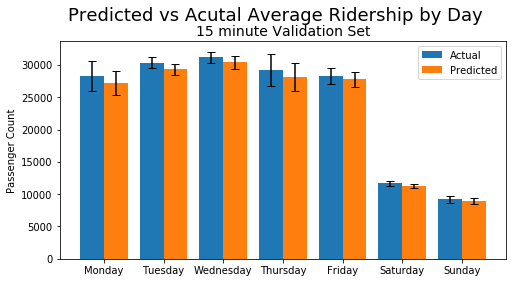

In [10]:
counts_by_day_xval_15 = avg_passenger_count_by_day_xval_15.ons['count']

ons_by_day_xval_15 = avg_passenger_count_by_day_xval_15.ons['mean']
ons_std_xval_15 = avg_passenger_count_by_day_xval_15.ons['std']
ons_error_xval_15 = 1.96*ons_std_xval_15/np.sqrt(counts_by_day_xval_15)

predictions_by_day_xval_15 = avg_passenger_count_by_day_xval_15.ons_predicted['mean']
predictions_std_xval_15 = avg_passenger_count_by_day_xval_15.ons_predicted['std']
predictions_error_xval_15 = 1.96*predictions_std_xval_15/np.sqrt(counts_by_day_xval_15)

plot_by_day(ons_by_day_xval_15, ons_error_xval_15,
            predictions_by_day_xval_15, predictions_error_xval_15,
            '15 minute Validation Set')

## Histograms of diff_ons_predicted by day

In [11]:
#test15.diff_ons_predicted[test15['day_of_week'] ==0].hist(bins = 100)

# 30 Minutes

In [12]:
test30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/30min/test.tsv.gz',
                      sep='\t')
xval30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/30min/xval.tsv.gz',
                      sep='\t')

predict_test30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_30min_test.txt',
                   header=None)
predict_xval30=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_30min_xval.txt',
                   header=None)

In [13]:
# add predictions column to data frame
test30['ons_predicted'] = predict_test30
xval30['ons_predicted'] = predict_xval30
# create a column for the difference between the actual ons and predicted ons
test30['diff_ons_predicted']=test30['ons']-test30['ons_predicted']
xval30['diff_ons_predicted']=xval30['ons']-xval30['ons_predicted']

## Test Set

In [14]:
# get sum by date
count_by_date_test_30 = test30.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_test_30['opd_date'] =pd.to_datetime(count_by_date_test_30['opd_date'])
count_by_date_test_30['dayofweek'] = count_by_date_test_30['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_test_30 = count_by_date_test_30.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_test_30

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  433650.0  28910.000000  4478.563051    15  419120.162347   
1         1  459105.0  30607.000000  2252.629131    15  439568.426230   
2         2  487850.0  30490.625000  2067.615015    16  473366.212379   
3         3  465752.0  29109.500000  4465.614075    16  455759.184307   
4         4  452594.0  28287.125000  2660.400368    16  438755.871727   
5         5  187259.0  11703.687500  1368.044869    16  183704.298262   
6         6  128684.0   9191.714286   974.404941    14  126029.401102   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  27941.344156  3708.893515    15       14529.837653   968.655844   
1  29304.561749  2111.702929    15       19536.573770  1302.438251   
2  29585.388274  2110.142134    16       14483.787621   905.236726   
3  28484.949019  3841.962242    16        9992.815693   624.550981   
4  27422.241983  2324.558402    16       13838.128273   864.883017   
5  11481.518641  1137.591619    16        3554.701738   222.168859   
6   9002.100079   808.605600    14        2654.598898   189.614207   

                     
          std count  
0  920.668293    15  
1  628.379917    15  
2  393.442607    16  
3  921.382678    16  
4  819.761359    16  
5  389.217452    16  
6  236.023943    14

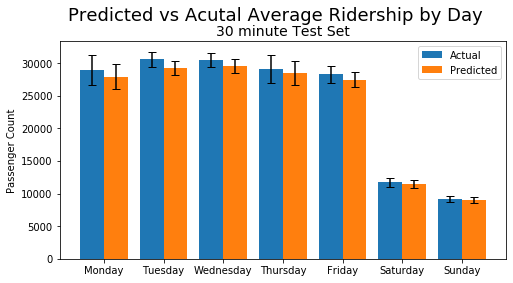

In [15]:
counts_by_day_test_30 = avg_passenger_count_by_day_test_30.ons['count']

ons_by_day_test_30 = avg_passenger_count_by_day_test_30.ons['mean']
ons_std_test_30 = avg_passenger_count_by_day_test_30.ons['std']
ons_error_test_30 = 1.96*ons_std_test_30/np.sqrt(counts_by_day_test_30)

predictions_by_day_test_30 = avg_passenger_count_by_day_test_30.ons_predicted['mean']
predictions_std_test_30 = avg_passenger_count_by_day_test_30.ons_predicted['std']
predictions_error_test_30 = 1.96*predictions_std_test_30/np.sqrt(counts_by_day_test_30)

plot_by_day(ons_by_day_test_30, ons_error_test_30,
            predictions_by_day_test_30, predictions_error_test_30,
            '30 minute Test Set')

# Validation Set

In [16]:
# get sum by date
count_by_date_xval_30 = xval30.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_xval_30['opd_date'] =pd.to_datetime(count_by_date_xval_30['opd_date'])
count_by_date_xval_30['dayofweek'] = count_by_date_xval_30['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_xval_30 = count_by_date_xval_30.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_xval_30

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  436352.0  29090.133333  4665.664535    15  422718.940556   
1         1  469021.0  31268.066667  1317.244118    15  448292.964759   
2         2  481895.0  30118.437500  2050.649490    16  467333.371275   
3         3  476215.0  29763.437500  5377.722058    16  465600.140559   
4         4  453139.0  28321.187500  2469.882621    16  439866.672439   
5         5  187788.0  11736.750000   896.705935    16  183773.781376   
6         6  126244.0   9017.428571  1182.971663    14  123729.333364   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  28181.262704  3833.512910    15       13633.059444   908.870630   
1  29886.197651  1257.983413    15       20728.035241  1381.869016   
2  29208.335705  1938.234407    16       14561.628725   910.101795   
3  29100.008785  4848.547433    16       10614.859441   663.428715   
4  27491.667027  2143.816691    16       13272.327561   829.520473   
5  11485.861336   778.364333    16        4014.218624   250.888664   
6   8837.809526  1021.852977    14        2514.666636   179.619045   

                      
           std count  
0  1058.930565    15  
1   423.224202    15  
2   597.020839    16  
3   894.146000    16  
4   745.989231    16  
5   333.881349    16  
6   280.414190    14

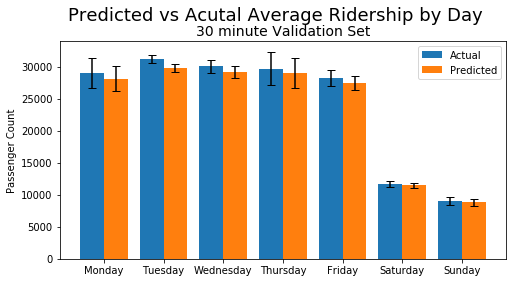

In [17]:
counts_by_day_xval_30 = avg_passenger_count_by_day_xval_30.ons['count']

ons_by_day_xval_30 = avg_passenger_count_by_day_xval_30.ons['mean']
ons_std_xval_30 = avg_passenger_count_by_day_xval_30.ons['std']
ons_error_xval_30 = 1.96*ons_std_xval_30/np.sqrt(counts_by_day_xval_30)

predictions_by_day_xval_30 = avg_passenger_count_by_day_xval_30.ons_predicted['mean']
predictions_std_xval_30 = avg_passenger_count_by_day_xval_30.ons_predicted['std']
predictions_error_xval_30 = 1.96*predictions_std_xval_30/np.sqrt(counts_by_day_xval_30)

plot_by_day(ons_by_day_xval_30, ons_error_xval_30,
            predictions_by_day_xval_30, predictions_error_xval_30,
            '30 minute Validation Set')

# 1 Hour

In [18]:
testHr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/hr/test.tsv.gz',
                      sep='\t')
xvalHr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/combined_data/hr/xval.tsv.gz',
                      sep='\t')

predict_test_hr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_hr_test.txt',
                   header=None)
predict_xval_hr=pd.read_csv('https://raw.githubusercontent.com/jacobw125/uw-msds-trac-capstone/master/predictions/final_nn_hr_xval.txt',
                   header=None)

In [19]:
# add predictions column to data frame
testHr['ons_predicted'] = predict_test_hr
xvalHr['ons_predicted'] = predict_xval_hr
# create a column for the difference between the actual ons and predicted ons
testHr['diff_ons_predicted']=testHr['ons']-testHr['ons_predicted']
xvalHr['diff_ons_predicted']=xvalHr['ons']-xvalHr['ons_predicted']

## Test Set

In [20]:
# get sum by date
count_by_date_test_hr = testHr.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_test_hr['opd_date'] =pd.to_datetime(count_by_date_test_hr['opd_date'])
count_by_date_test_hr['dayofweek'] = count_by_date_test_hr['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_test_hr = count_by_date_test_hr.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_test_hr

dayofweek       ons                                 ons_predicted  \
                  sum        mean          std count            sum   
0         0  437088.0  29139.2000  3920.409949    15  428212.678226   
1         1  473643.0  31576.2000  2711.924414    15  463576.342665   
2         2  488618.0  30538.6250  2755.537283    16  470796.657468   
3         3  469008.0  29313.0000  5282.860955    16  458660.589684   
4         4  456793.0  28549.5625  2735.007763    16  443988.987400   
5         5  178036.0  11127.2500  1301.123643    16  176006.318753   
6         6  127421.0   9101.5000  1369.902565    14  125451.089395   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  28547.511882  3115.187330    15        8875.321774   591.688118   
1  30905.089511  2613.927032    15       10066.657335   671.110489   
2  29424.791092  2623.925645    16       17821.342532  1113.833908   
3  28666.286855  4213.239155    16       10347.410316   646.713145   
4  27749.311713  2467.680700    16       12804.012600   800.250787   
5  11000.394922  1258.076022    16        2029.681247   126.855078   
6   8960.792100  1356.773076    14        1969.910605   140.707900   

                      
           std count  
0  1008.191135    15  
1   532.764027    15  
2   396.142379    16  
3  1379.630590    16  
4   888.790947    16  
5   411.010455    16  
6   194.957232    14

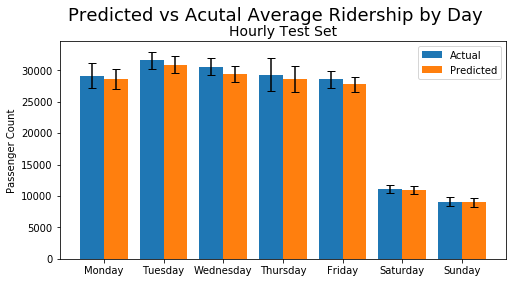

In [21]:
counts_by_day_test_hr = avg_passenger_count_by_day_test_hr.ons['count']

ons_by_day_test_hr = avg_passenger_count_by_day_test_hr.ons['mean']
ons_std_test_hr = avg_passenger_count_by_day_test_hr.ons['std']
ons_error_test_hr = 1.96*ons_std_test_hr/np.sqrt(counts_by_day_test_hr)

predictions_by_day_test_hr = avg_passenger_count_by_day_test_hr.ons_predicted['mean']
predictions_std_test_hr = avg_passenger_count_by_day_test_hr.ons_predicted['std']
predictions_error_test_hr = 1.96*predictions_std_test_hr/np.sqrt(counts_by_day_test_hr)

plot_by_day(ons_by_day_test_hr, ons_error_test_hr,
            predictions_by_day_test_hr, predictions_error_test_hr,
            'Hourly Test Set')

## Validation Set

In [22]:
# get sum by date
count_by_date_xval_hr = xvalHr.groupby('opd_date',as_index=False).agg({'ons':'sum',
                                                              'ons_predicted':'sum',
                                                              'diff_ons_predicted':'sum',
                                                             })
# get day of week for the date
count_by_date_xval_hr['opd_date'] =pd.to_datetime(count_by_date_xval_hr['opd_date'])
count_by_date_xval_hr['dayofweek'] = count_by_date_xval_hr['opd_date'].dt.dayofweek

# get mean, standard deviation and variance for ons, predicted ons, and delta between the two
avg_passenger_count_by_day_xval_hr = count_by_date_xval_hr.groupby('dayofweek',
                                                                  as_index=False).agg({'ons':['sum','mean',
                                                                                              'std', 'count'],
                                                                                       'ons_predicted':['sum','mean',
                                                                                                        'std', 'count'],
                                                                                       'diff_ons_predicted': ['sum','mean',
                                                                                                              'std', 'count']
                                                                                      })

avg_passenger_count_by_day_xval_hr

dayofweek       ons                                   ons_predicted  \
                  sum          mean          std count            sum   
0         0  449110.0  29940.666667  5735.426795    15  437962.935694   
1         1  480975.0  32065.000000  3054.268301    15  468555.210712   
2         2  496690.0  31043.125000  2737.000472    16  478443.486047   
3         3  484873.0  30304.562500  5340.314747    16  473829.683644   
4         4  461787.0  28861.687500  2538.236204    16  447740.944160   
5         5  195282.0  12205.125000  1438.395721    16  190037.243950   
6         6  135226.0   9659.000000  1175.387203    14  133780.076225   

                                   diff_ons_predicted               \
           mean          std count                sum         mean   
0  29197.529046  4759.286444    15       11147.064306   743.137620   
1  31237.014047  2829.324012    15       12419.789288   827.985953   
2  29902.717878  2413.460626    16       18246.513953  1140.407122   
3  29614.355228  4579.569969    16       11043.316356   690.207272   
4  27983.809010  2150.243463    16       14046.055840   877.878490   
5  11877.327747  1285.664199    16        5244.756050   327.797253   
6   9555.719730  1130.250140    14        1445.923775   103.280270   

                      
           std count  
0  1112.049608    15  
1   569.519284    15  
2   546.434107    16  
3  1116.371899    16  
4   716.991572    16  
5   404.781664    16  
6   202.939604    14

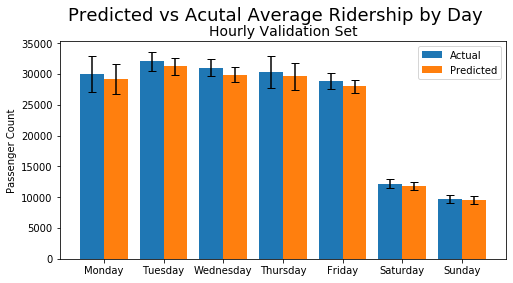

In [23]:
counts_by_day_xval_hr = avg_passenger_count_by_day_xval_hr.ons['count']

ons_by_day_xval_hr = avg_passenger_count_by_day_xval_hr.ons['mean']
ons_std_xval_hr = avg_passenger_count_by_day_xval_hr.ons['std']
ons_error_xval_hr = 1.96*ons_std_xval_hr/np.sqrt(counts_by_day_xval_hr)

predictions_by_day_xval_hr = avg_passenger_count_by_day_xval_hr.ons_predicted['mean']
predictions_std_xval_hr = avg_passenger_count_by_day_xval_hr.ons_predicted['std']
predictions_error_xval_hr = 1.96*predictions_std_xval_hr/np.sqrt(counts_by_day_xval_hr)

plot_by_day(ons_by_day_xval_hr, ons_error_xval_hr,
            predictions_by_day_xval_hr, predictions_error_xval_hr,
            'Hourly Validation Set')